In [1]:
import numpy as np

In [3]:


def _make_positions(n, width, t):
    """폭 width 안에 n개의 벽 중심 좌표(등간격) 생성. 양 끝도 균등 분배."""
    # 유효 배치 폭 = width, 벽 중심 간격 = width / n
    # 중심은 cell 경계에 정확히 걸리지 않도록 살짝 가운데 정렬
    return (np.arange(n) + 0.5) * (width / n)

def _union_mask_lines(N, t, width=10.0, res=0.01, orientation="vertical"):
    """한 방향(일자 무늬) 벽들의 2D 합집합 마스크 생성"""
    assert N >= 0
    assert N == 0 or N * t <= width, "한 방향 벽 두께 합(N*t)이 폭(10mm)을 넘으면 안 됩니다."
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width, t)
    half = t / 2.0

    if orientation == "vertical":
        # 세로 벽: |x - x_i| <= t/2
        for cx in centers:
            mask |= (np.abs(X - cx) <= half)
    else:
        # 가로 벽: |y - y_j| <= t/2
        for cy in centers:
            mask |= (np.abs(Y - cy) <= half)
    return mask, res

def _union_mask_grid(N, t, width=10.0, res=0.01):
    """두 방향(격자 무늬) 벽들의 2D 합집합 마스크 생성"""
    assert N >= 0
    assert N == 0 or N * t <= width, "한 방향 벽 두께 합(N*t)이 폭(10mm)을 넘으면 안 됩니다."
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width, t)
    half = t / 2.0

    # 세로 + 가로 모두 OR 합집합
    for c in centers:
        mask |= (np.abs(X - c) <= half)  # vertical
        mask |= (np.abs(Y - c) <= half)  # horizontal
    return mask, res

def _area_and_perimeter_from_mask(mask, res):
    """2D 이진 마스크로부터 면적(mm^2)과 외곽선 둘레(mm) 계산 (4-이웃 경계)."""
    area = mask.sum() * (res * res)

    # 경계(둘레): 인접 픽셀 간 값이 다른 에지 개수 × res
    # 수평 에지
    diff_h = np.diff(mask, axis=1)
    # 수직 에지
    diff_v = np.diff(mask, axis=0)
    # 경계 개수 = True↔False 변화 수의 절대값 합
    edges_h = np.count_nonzero(diff_h)
    edges_v = np.count_nonzero(diff_v)

    # 좌/우/상/하의 외곽도 포함해야 하므로, 도메인 경계쪽의 True도 더해준다
    # 좌측 세로선
    edges_left  = np.count_nonzero(mask[:, 0])
    # 우측 세로선
    edges_right = np.count_nonzero(mask[:, -1])
    # 하단 가로선
    edges_bottom = np.count_nonzero(mask[0, :])
    # 상단 가로선
    edges_top    = np.count_nonzero(mask[-1, :])

    # 수평 경계 수: 내부 변화(열 방향 diff) + 위/아래 외곽
    # 수직 경계 수: 내부 변화(행 방향 diff) + 좌/우 외곽
    # 둘레 = (수평경계수 + 수직경계수) * res
    perim_count = edges_h + edges_v + edges_left + edges_right + edges_bottom + edges_top
    perimeter = perim_count * res
    return area, perimeter

def surface_area_extrusion(area_2d, perimeter_2d, height):
    """
    바닥 2D 합집합(면적, 둘레)을 높이 height로 압출했을 때의 총 외부 표면적(mm^2).
    SA = (둘레 × 높이) + 2 × 면적
    """
    return perimeter_2d * height + 2.0 * area_2d

def compute_surface_areas(N, t, h, width=10.0, res=0.01, sanity_check=True):
    """
    N: 한 방향의 벽 개수
    t: 벽 두께(mm)
    h: 벽 높이(mm)
    width: 바닥 폭(기본 10mm)
    res: 2D 격자 해상도(mm). 더 작으면 더 정확, 더 느림.

    반환:
      dict {
        'lines': {'area2d','perimeter2d','surface_area3d'},
        'grid' : {'area2d','perimeter2d','surface_area3d'}
      }
    """
    # --- 일자(한 방향) ---
    mask_lines, res_used = _union_mask_lines(N, t, width, res, orientation="vertical")
    A_lines, P_lines = _area_and_perimeter_from_mask(mask_lines, res_used)
    SA_lines = surface_area_extrusion(A_lines, P_lines, h)

    # --- 격자(두 방향) ---
    mask_grid, res_used = _union_mask_grid(N, t, width, res)
    A_grid, P_grid = _area_and_perimeter_from_mask(mask_grid, res_used)
    SA_grid = surface_area_extrusion(A_grid, P_grid, h)

    result = {
        'lines': {
            'area2d_mm2': A_lines,
            'perimeter2d_mm': P_lines,
            'surface_area3d_mm2': SA_lines
        },
        'grid': {
            'area2d_mm2': A_grid,
            'perimeter2d_mm': P_grid,
            'surface_area3d_mm2': SA_grid
        }
    }

    if sanity_check:
        # 면적의 해석적 근사(겹침 고려)와 비교해서 대략적인 체크도 제공
        # 일자: A = N * t * width
        A_lines_analytic = N * t * width
        # 격자: A = 2*N*t*width - N^2 * t^2   (교차부 t×t 중복 제거)
        A_grid_analytic  = 2 * N * t * width - (N**2) * (t**2)
        result['sanity'] = {
            'area2d_lines_analytic_mm2' : A_lines_analytic,
            'area2d_grid_analytic_mm2'  : A_grid_analytic
        }

    return result



In [5]:
N = 8       # 한 방향 벽 개수
t = 1     # 벽 두께(mm)
h = 5.0     # 벽 높이(mm)
# 해상도는 0.01mm 권장. 더 빠르게 하고 싶으면 0.02~0.05로 올리면 됨
res = 0.01

out = compute_surface_areas(N, t, h, width=10.0, res=res)
print("=== 일자 무늬 ===")
print(f"2D 면적  (mm^2): {out['lines']['area2d_mm2']:.4f}")
print(f"2D 둘레  (mm)  : {out['lines']['perimeter2d_mm']:.4f}")
print(f"3D 표면적(mm^2): {out['lines']['surface_area3d_mm2']:.4f}")

print("\n=== 격자 무늬 ===")
print(f"2D 면적  (mm^2): {out['grid']['area2d_mm2']:.4f}")
print(f"2D 둘레  (mm)  : {out['grid']['perimeter2d_mm']:.4f}")
print(f"3D 표면적(mm^2): {out['grid']['surface_area3d_mm2']:.4f}")

if 'sanity' in out:
    print("\n[면적 해석적 근사 체크]")
    print(f"일자 근사(mm^2):  {out['sanity']['area2d_lines_analytic_mm2']:.4f}")
    print(f"격자 근사(mm^2):  {out['sanity']['area2d_grid_analytic_mm2']:.4f}")

=== 일자 무늬 ===
2D 면적  (mm^2): 80.0000
2D 둘레  (mm)  : 176.0000
3D 표면적(mm^2): 1040.0000

=== 격자 무늬 ===
2D 면적  (mm^2): 96.0000
2D 둘레  (mm)  : 96.0000
3D 표면적(mm^2): 672.0000

[면적 해석적 근사 체크]
일자 근사(mm^2):  80.0000
격자 근사(mm^2):  96.0000


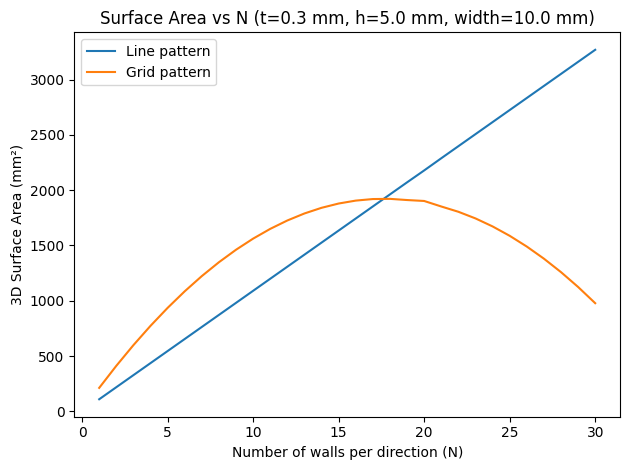

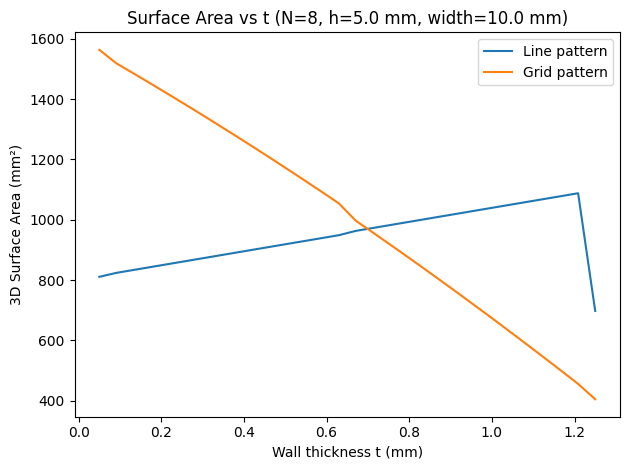

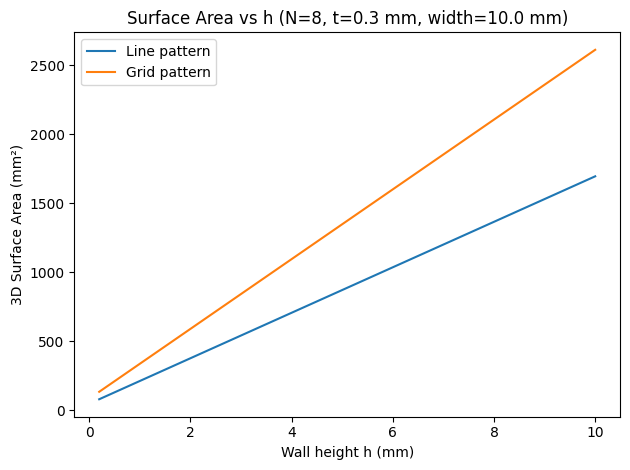


=== Baseline Snapshot (N=8, t=0.3 mm, h=5.0 mm) ===
Pattern  2D Area (mm²)  2D Perimeter (mm)  3D Surface Area (mm²)
   Line          24.00              164.8                 872.00
   Grid          42.24              252.8                1348.48


In [7]:
# DIW surface area comparison: Grid vs Line pattern (within 10x10x10 mm)
# Variable sweep visualization (N, t, h)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------- Core geometry helpers ----------------
def _make_positions(n, width):
    if n <= 0:
        return np.array([])
    return (np.arange(n) + 0.5) * (width / n)

def _union_mask_lines(N, t, width=10.0, res=0.02, orientation="vertical"):
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width)
    half = t / 2.0

    if orientation == "vertical":
        for cx in centers:
            mask |= (np.abs(X - cx) <= half)
    else:
        for cy in centers:
            mask |= (np.abs(Y - cy) <= half)
    return mask, res

def _union_mask_grid(N, t, width=10.0, res=0.02):
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width)
    half = t / 2.0

    for c in centers:
        mask |= (np.abs(X - c) <= half)  # vertical
        mask |= (np.abs(Y - c) <= half)  # horizontal
    return mask, res

def _area_and_perimeter_from_mask(mask, res):
    area = mask.sum() * (res * res)
    diff_h = np.diff(mask, axis=1)
    diff_v = np.diff(mask, axis=0)
    edges_h = np.count_nonzero(diff_h)
    edges_v = np.count_nonzero(diff_v)
    edges_left   = np.count_nonzero(mask[:, 0])
    edges_right  = np.count_nonzero(mask[:, -1])
    edges_bottom = np.count_nonzero(mask[0, :])
    edges_top    = np.count_nonzero(mask[-1, :])
    perim_count = edges_h + edges_v + edges_left + edges_right + edges_bottom + edges_top
    perimeter = perim_count * res
    return area, perimeter

def surface_area_extrusion(area_2d, perimeter_2d, height):
    return perimeter_2d * height + 2.0 * area_2d

def compute_surface_areas(N, t, h, width=10.0, res=0.02):
    if N * t > width + 1e-9:
        raise ValueError("Constraint violated: N*t must be ≤ width.")

    mask_lines, res_used = _union_mask_lines(N, t, width, res, "vertical")
    A_lines, P_lines = _area_and_perimeter_from_mask(mask_lines, res_used)
    SA_lines = surface_area_extrusion(A_lines, P_lines, h)

    mask_grid, res_used = _union_mask_grid(N, t, width, res)
    A_grid, P_grid = _area_and_perimeter_from_mask(mask_grid, res_used)
    SA_grid = surface_area_extrusion(A_grid, P_grid, h)

    return {
        'lines': {'A2D': A_lines, 'P2D': P_lines, 'SA3D': SA_lines},
        'grid':  {'A2D': A_grid,  'P2D': P_grid,  'SA3D': SA_grid },
    }

# ---------------- Baseline parameters ----------------
W  = 10.0  # mm
N0 = 8
t0 = 0.3   # mm
h0 = 5.0   # mm
res = 0.02

# ---------------- 1) Sweep N ----------------
N_max_by_t = max(1, int(np.floor(W / t0)))
N_vals = np.arange(1, min(30, N_max_by_t) + 1)
SA_lines_vsN = []
SA_grid_vsN  = []
for N in N_vals:
    out = compute_surface_areas(N, t0, h0, width=W, res=res)
    SA_lines_vsN.append(out['lines']['SA3D'])
    SA_grid_vsN.append(out['grid']['SA3D'])

plt.figure()
plt.plot(N_vals, SA_lines_vsN, label="Line pattern")
plt.plot(N_vals, SA_grid_vsN,  label="Grid pattern")
plt.xlabel("Number of walls per direction (N)")
plt.ylabel("3D Surface Area (mm²)")
plt.title(f"Surface Area vs N (t={t0} mm, h={h0} mm, width={W} mm)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- 2) Sweep t ----------------
t_min = 0.05
t_max = min(1.5, W / N0 - 1e-6)
t_vals = np.linspace(t_min, t_max, 30)
SA_lines_vst = []
SA_grid_vst  = []
for t in t_vals:
    out = compute_surface_areas(N0, float(t), h0, width=W, res=res)
    SA_lines_vst.append(out['lines']['SA3D'])
    SA_grid_vst.append(out['grid']['SA3D'])

plt.figure()
plt.plot(t_vals, SA_lines_vst, label="Line pattern")
plt.plot(t_vals, SA_grid_vst,  label="Grid pattern")
plt.xlabel("Wall thickness t (mm)")
plt.ylabel("3D Surface Area (mm²)")
plt.title(f"Surface Area vs t (N={N0}, h={h0} mm, width={W} mm)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- 3) Sweep h ----------------
h_vals = np.linspace(0.2, 10.0, 30)
SA_lines_vsh = []
SA_grid_vsh  = []
for h in h_vals:
    out = compute_surface_areas(N0, t0, float(h), width=W, res=res)
    SA_lines_vsh.append(out['lines']['SA3D'])
    SA_grid_vsh.append(out['grid']['SA3D'])

plt.figure()
plt.plot(h_vals, SA_lines_vsh, label="Line pattern")
plt.plot(h_vals, SA_grid_vsh,  label="Grid pattern")
plt.xlabel("Wall height h (mm)")
plt.ylabel("3D Surface Area (mm²)")
plt.title(f"Surface Area vs h (N={N0}, t={t0} mm, width={W} mm)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Baseline snapshot table ----------------
base_out = compute_surface_areas(N0, t0, h0, width=W, res=res)
df = pd.DataFrame({
    "Pattern": ["Line", "Grid"],
    "2D Area (mm²)": [base_out['lines']['A2D'], base_out['grid']['A2D']],
    "2D Perimeter (mm)": [base_out['lines']['P2D'], base_out['grid']['P2D']],
    "3D Surface Area (mm²)": [base_out['lines']['SA3D'], base_out['grid']['SA3D']],
})
print("\n=== Baseline Snapshot (N={}, t={} mm, h={} mm) ===".format(N0, t0, h0))
print(df.to_string(index=False))


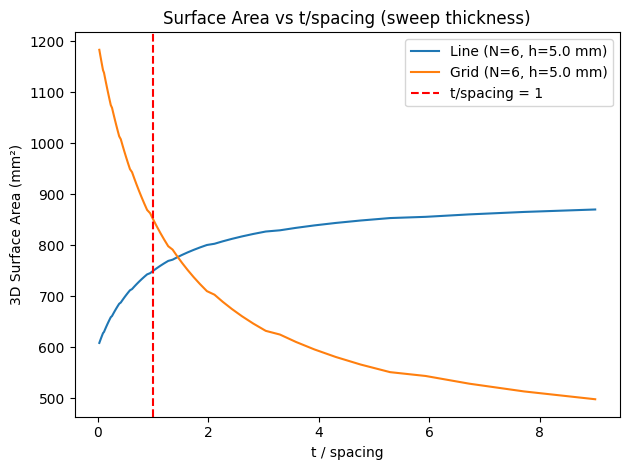

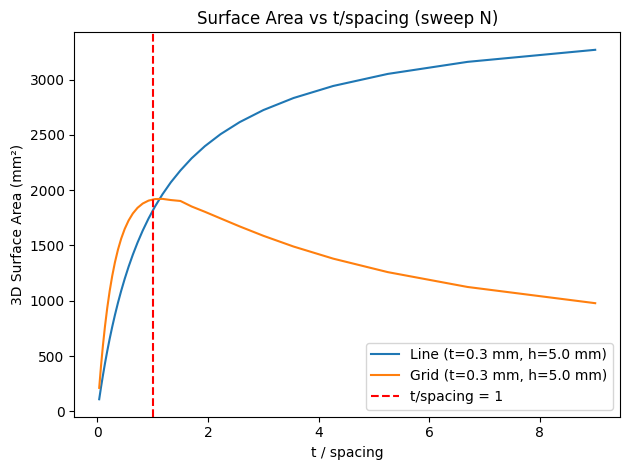

In [10]:
# Compare 3D Surface Area vs (wall thickness / spacing between walls)
# Add vertical reference line at ratio = 1

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------- Core geometry helpers ----------------
def _make_positions(n, width):
    if n <= 0:
        return np.array([])
    return (np.arange(n) + 0.5) * (width / n)

def _union_mask_lines(N, t, width=10.0, res=0.02, orientation="vertical"):
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width)
    half = t / 2.0

    if orientation == "vertical":
        for cx in centers:
            mask |= (np.abs(X - cx) <= half)
    else:
        for cy in centers:
            mask |= (np.abs(Y - cy) <= half)
    return mask, res

def _union_mask_grid(N, t, width=10.0, res=0.02):
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width)
    half = t / 2.0

    for c in centers:
        mask |= (np.abs(X - c) <= half)  # vertical
        mask |= (np.abs(Y - c) <= half)  # horizontal
    return mask, res

def _area_and_perimeter_from_mask(mask, res):
    area = mask.sum() * (res * res)
    diff_h = np.diff(mask, axis=1)
    diff_v = np.diff(mask, axis=0)
    edges_h = np.count_nonzero(diff_h)
    edges_v = np.count_nonzero(diff_v)
    edges_left   = np.count_nonzero(mask[:, 0])
    edges_right  = np.count_nonzero(mask[:, -1])
    edges_bottom = np.count_nonzero(mask[0, :])
    edges_top    = np.count_nonzero(mask[-1, :])
    perim_count = edges_h + edges_v + edges_left + edges_right + edges_bottom + edges_top
    perimeter = perim_count * res
    return area, perimeter

def surface_area_extrusion(area_2d, perimeter_2d, height):
    return perimeter_2d * height + 2.0 * area_2d

def compute_surface_areas(N, t, h, width=10.0, res=0.02):
    if N * t > width + 1e-12:
        raise ValueError("Constraint violated: N * t must be ≤ width.")
    # line
    mask_lines, res_used = _union_mask_lines(N, t, width, res, orientation="vertical")
    A_lines, P_lines = _area_and_perimeter_from_mask(mask_lines, res_used)
    SA_lines = surface_area_extrusion(A_lines, P_lines, h)
    # grid
    mask_grid, res_used = _union_mask_grid(N, t, width, res)
    A_grid, P_grid = _area_and_perimeter_from_mask(mask_grid, res_used)
    SA_grid = surface_area_extrusion(A_grid, P_grid, h)
    return {'lines': {'SA3D': SA_lines},
            'grid':  {'SA3D': SA_grid }}

# -------- Spacing & ratio helpers --------
def pitch(width, N):
    return width / N

def spacing_clear(width, N, t):
    return pitch(width, N) - t

def ratio_t_over_spacing(width, N, t):
    s = spacing_clear(width, N, t)
    if s <= 0:
        return np.inf
    return t / s

# ---------------- Parameters ----------------
W  = 10.0
res = 0.02

# Baseline for sweep A (vary t)
N_fix = 6
h_fix = 5.0
t_min = 0.05
t_max = min(1.5, W / N_fix - 1e-6)
t_vals = np.linspace(t_min, t_max, 60)

# Baseline for sweep B (vary N)
t_fix = 0.3
h_fixB = 5.0
N_max_by_t = int(np.floor(W / t_fix))
N_vals = np.arange(1, max(2, min(30, N_max_by_t)) + 1)

# ---------------- (A) Sweep thickness ----------------
ratios_A, SA_line_A, SA_grid_A = [], [], []
for t in t_vals:
    r = ratio_t_over_spacing(W, N_fix, t)
    if np.isinf(r) or r <= 0: 
        continue
    out = compute_surface_areas(N_fix, float(t), h_fix, width=W, res=res)
    ratios_A.append(r)
    SA_line_A.append(out['lines']['SA3D'])
    SA_grid_A.append(out['grid']['SA3D'])

plt.figure()
plt.plot(ratios_A, SA_line_A, label=f"Line (N={N_fix}, h={h_fix} mm)")
plt.plot(ratios_A, SA_grid_A, label=f"Grid (N={N_fix}, h={h_fix} mm)")
plt.axvline(1.0, color="red", linestyle="--", label="t/spacing = 1")
plt.xlabel("t / spacing")
plt.ylabel("3D Surface Area (mm²)")
plt.title("Surface Area vs t/spacing (sweep thickness)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- (B) Sweep N ----------------
ratios_B, SA_line_B, SA_grid_B = [], [], []
for N in N_vals:
    if N * t_fix >= W:
        continue
    r = ratio_t_over_spacing(W, int(N), t_fix)
    if np.isinf(r) or r <= 0: 
        continue
    out = compute_surface_areas(int(N), t_fix, h_fixB, width=W, res=res)
    ratios_B.append(r)
    SA_line_B.append(out['lines']['SA3D'])
    SA_grid_B.append(out['grid']['SA3D'])

plt.figure()
plt.plot(ratios_B, SA_line_B, label=f"Line (t={t_fix} mm, h={h_fixB} mm)")
plt.plot(ratios_B, SA_grid_B, label=f"Grid (t={t_fix} mm, h={h_fixB} mm)")
plt.axvline(1.0, color="red", linestyle="--", label="t/spacing = 1")
plt.xlabel("t / spacing")
plt.ylabel("3D Surface Area (mm²)")
plt.title("Surface Area vs t/spacing (sweep N)")
plt.legend()
plt.tight_layout()
plt.show()


(1.2893637561041942,)


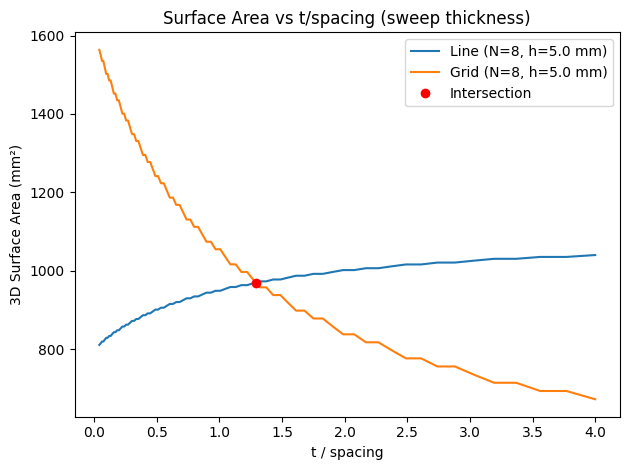

(1.1238994402412692,)


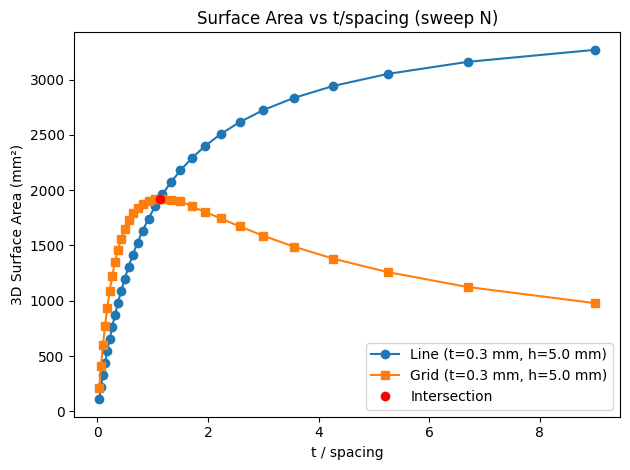

Intersections (sweep thickness): (ratio=1.2894, SA=969.82 mm^2)
Intersections (sweep N):         (ratio=1.1239, SA=1921.04 mm^2)


In [18]:
# DIW: 3D Surface Area vs (thickness / spacing) with intersection markers
# - Pattern types: Line (1 direction), Grid (2 directions)
# - Domain: 10 x 10 x 10 mm
# - Two sweeps:
#     (A) Vary thickness t at fixed N, h
#     (B) Vary number of walls N at fixed t, h
#
# Outputs:
#   - Two plots with Line/Grid curves and intersection marker(s)
#   - Printed intersection coordinates (ratio, surface area)

import numpy as np
import matplotlib.pyplot as plt

# ---------------- Core geometry helpers ----------------
def _make_positions(n, width):
    """Return n centers evenly spaced across [0,width), centered within each pitch."""
    if n <= 0:
        return np.array([])
    return (np.arange(n) + 0.5) * (width / n)

def _union_mask_lines(N, t, width=10.0, res=0.02, orientation="vertical"):
    """2D union mask for one-direction walls (Line pattern)."""
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width)
    half = t / 2.0

    if orientation == "vertical":
        for cx in centers:
            mask |= (np.abs(X - cx) <= half)
    else:
        for cy in centers:
            mask |= (np.abs(Y - cy) <= half)
    return mask, res

def _union_mask_grid(N, t, width=10.0, res=0.02):
    """2D union mask for two-direction walls (Grid pattern)."""
    xs = np.arange(0, width, res)
    ys = np.arange(0, width, res)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    mask = np.zeros_like(X, dtype=bool)

    centers = _make_positions(N, width)
    half = t / 2.0

    for c in centers:
        mask |= (np.abs(X - c) <= half)  # vertical walls
        mask |= (np.abs(Y - c) <= half)  # horizontal walls
    return mask, res

def _area_and_perimeter_from_mask(mask, res):
    """Compute 2D union area (mm^2) and perimeter (mm) from a boolean mask."""
    area = mask.sum() * (res * res)

    # Perimeter via 4-neighborhood transitions + domain borders
    diff_h = np.diff(mask, axis=1)
    diff_v = np.diff(mask, axis=0)
    edges_h = np.count_nonzero(diff_h)
    edges_v = np.count_nonzero(diff_v)
    edges_left   = np.count_nonzero(mask[:, 0])
    edges_right  = np.count_nonzero(mask[:, -1])
    edges_bottom = np.count_nonzero(mask[0, :])
    edges_top    = np.count_nonzero(mask[-1, :])
    perim_count = edges_h + edges_v + edges_left + edges_right + edges_bottom + edges_top
    perimeter = perim_count * res
    return area, perimeter

def surface_area_extrusion(area_2d, perimeter_2d, height):
    """SA(3D) = (perimeter * height) + 2 * area."""
    return perimeter_2d * height + 2.0 * area_2d

def compute_surface_areas(N, t, h, width=10.0, res=0.02):
    """Return 3D surface areas for Line and Grid patterns."""
    if N * t > width + 1e-12:
        raise ValueError("Constraint violated: N * t must be ≤ width (no overlap in one direction).")

    # Line
    mask_lines, res_used = _union_mask_lines(N, t, width, res, orientation="vertical")
    A_lines, P_lines = _area_and_perimeter_from_mask(mask_lines, res_used)
    SA_lines = surface_area_extrusion(A_lines, P_lines, h)

    # Grid
    mask_grid, res_used = _union_mask_grid(N, t, width, res)
    A_grid, P_grid = _area_and_perimeter_from_mask(mask_grid, res_used)
    SA_grid = surface_area_extrusion(A_grid, P_grid, h)

    return {
        'lines': {'A2D': A_lines, 'P2D': P_lines, 'SA3D': SA_lines},
        'grid' : {'A2D': A_grid,  'P2D': P_grid,  'SA3D': SA_grid},
    }

# -------- Spacing & ratio helpers --------
def pitch(width, N):
    """Center-to-center pitch."""
    return width / N

def spacing_clear(width, N, t):
    """Clear spacing between adjacent walls."""
    return pitch(width, N) - t

def ratio_t_over_spacing(width, N, t):
    """t / (pitch - t). Returns np.inf if spacing <= 0."""
    s = spacing_clear(width, N, t)
    if s <= 0:
        return np.inf
    return t / s

# --------- Intersection finder ----------
def find_intersections(x, y1, y2):
    """
    Find all linear intersections between two curves sampled on the same x-grid.
    Returns list of (x_int, y_int) where y1(x_int) == y2(x_int) via linear interpolation.
    """
    x = np.asarray(x)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    d = y1 - y2
    pts = []
    for i in range(len(d) - 1):
        if d[i] == 0:
            pts.append((x[i], y1[i]))
        elif d[i] * d[i+1] < 0:
            # Linear interpolate root of d
            x0, x1 = x[i], x[i+1]
            d0, d1 = d[i], d[i+1]
            x_int = x0 - d0 * (x1 - x0) / (d1 - d0)
            # Interpolate y on either curve
            y_int = y1[i] + (y1[i+1] - y1[i]) * (x_int - x0) / (x1 - x0)
            pts.append((x_int, y_int))
    return pts

# ---------------- Parameters ----------------
W   = 10.0   # mm
res = 0.02   # mm (use 0.01 for higher accuracy, slower)

# (A) Sweep thickness t at fixed N, h
N_fix = 8
h_fix = 5.0
t_min = 0.05
t_max = 1   # ensure N_fix * t < W
t_vals = np.linspace(t_min, t_max, 80)

# (B) Sweep number of walls N at fixed t, h
t_fix  = 0.3
h_fixB = 5.0
N_max_by_t = int(np.floor(W / t_fix))
N_vals = np.arange(1, max(2, min(30, N_max_by_t)) + 1)

# ---------------- (A) Sweep thickness ----------------
ratios_A, SA_line_A, SA_grid_A = [], [], []
for t in t_vals:
    if N_fix * t >= W:
        continue
    r = ratio_t_over_spacing(W, N_fix, t)
    if not np.isfinite(r) or r <= 0:
        continue
    out = compute_surface_areas(N_fix, float(t), h_fix, width=W, res=res)
    ratios_A.append(r)
    SA_line_A.append(out['lines']['SA3D'])
    SA_grid_A.append(out['grid']['SA3D'])

# intersections for (A)
ints_A = find_intersections(ratios_A, SA_line_A, SA_grid_A)

plt.figure()
plt.plot(ratios_A, SA_line_A, label=f"Line (N={N_fix}, h={h_fix} mm)")
plt.plot(ratios_A, SA_grid_A, label=f"Grid (N={N_fix}, h={h_fix} mm)")
if ints_A:
    xs, ys = zip(*ints_A)
    print(xs)
    plt.plot(xs, ys, 'ro', label="Intersection")
plt.xlabel("t / spacing")
plt.ylabel("3D Surface Area (mm²)")
plt.title("Surface Area vs t/spacing (sweep thickness)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- (B) Sweep N ----------------
ratios_B, SA_line_B, SA_grid_B = [], [], []
for N in N_vals:
    if N * t_fix >= W:
        continue
    r = ratio_t_over_spacing(W, int(N), t_fix)
    if not np.isfinite(r) or r <= 0:
        continue
    out = compute_surface_areas(int(N), t_fix, h_fixB, width=W, res=res)
    ratios_B.append(r)
    SA_line_B.append(out['lines']['SA3D'])
    SA_grid_B.append(out['grid']['SA3D'])

# intersections for (B)
ints_B = find_intersections(ratios_B, SA_line_B, SA_grid_B)

plt.figure()
plt.plot(ratios_B, SA_line_B,'-o', label=f"Line (t={t_fix} mm, h={h_fixB} mm)")
plt.plot(ratios_B, SA_grid_B,'-s', label=f"Grid (t={t_fix} mm, h={h_fixB} mm)")
if ints_B:
    xs, ys = zip(*ints_B)
    print(xs)
    plt.plot(xs, ys, 'ro', label="Intersection")
plt.xlabel("t / spacing")
plt.ylabel("3D Surface Area (mm²)")
plt.title("Surface Area vs t/spacing (sweep N)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Print intersections ----------------
def _fmt_points(points):
    if not points:
        return "None"
    return ", ".join([f"(ratio={x:.4f}, SA={y:.2f} mm^2)" for x, y in points])

print("Intersections (sweep thickness):", _fmt_points(ints_A))
print("Intersections (sweep N):        ", _fmt_points(ints_B))


(2.11546629312954,)


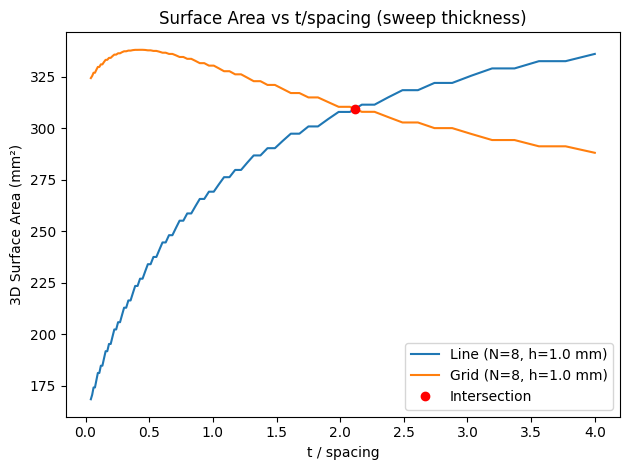

(1.5378197439516912,)


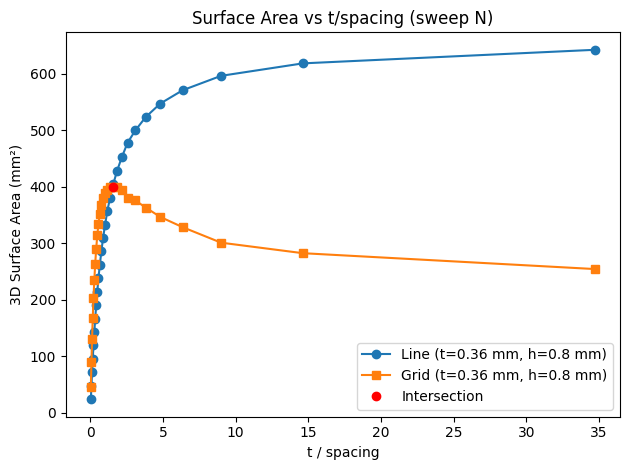

Intersections (sweep thickness): (ratio=2.1155, SA=309.31 mm^2)
Intersections (sweep N):         (ratio=1.5378, SA=400.08 mm^2)


In [21]:
# ---------------- Parameters ----------------
W   = 10.0   # mm
res = 0.01   # mm (use 0.01 for higher accuracy, slower)

# (A) Sweep thickness t at fixed N, h
N_fix = 8
h_fix = 1.0
t_min = 0.05
t_max = 1   # ensure N_fix * t < W
t_vals = np.linspace(t_min, t_max, 80)

# (B) Sweep number of walls N at fixed t, h
t_fix  = 0.36
h_fixB = 0.8
N_max_by_t = int(np.floor(W / t_fix))
N_vals = np.arange(1, max(2, min(30, N_max_by_t)) + 1)

# ---------------- (A) Sweep thickness ----------------
ratios_A, SA_line_A, SA_grid_A = [], [], []
for t in t_vals:
    if N_fix * t >= W:
        continue
    r = ratio_t_over_spacing(W, N_fix, t)
    if not np.isfinite(r) or r <= 0:
        continue
    out = compute_surface_areas(N_fix, float(t), h_fix, width=W, res=res)
    ratios_A.append(r)
    SA_line_A.append(out['lines']['SA3D'])
    SA_grid_A.append(out['grid']['SA3D'])

# intersections for (A)
ints_A = find_intersections(ratios_A, SA_line_A, SA_grid_A)

plt.figure()
plt.plot(ratios_A, SA_line_A, label=f"Line (N={N_fix}, h={h_fix} mm)")
plt.plot(ratios_A, SA_grid_A, label=f"Grid (N={N_fix}, h={h_fix} mm)")
if ints_A:
    xs, ys = zip(*ints_A)
    print(xs)
    plt.plot(xs, ys, 'ro', label="Intersection")
plt.xlabel("t / spacing")
plt.ylabel("3D Surface Area (mm²)")
plt.title("Surface Area vs t/spacing (sweep thickness)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- (B) Sweep N ----------------
ratios_B, SA_line_B, SA_grid_B = [], [], []
for N in N_vals:
    if N * t_fix >= W:
        continue
    r = ratio_t_over_spacing(W, int(N), t_fix)
    if not np.isfinite(r) or r <= 0:
        continue
    out = compute_surface_areas(int(N), t_fix, h_fixB, width=W, res=res)
    ratios_B.append(r)
    SA_line_B.append(out['lines']['SA3D'])
    SA_grid_B.append(out['grid']['SA3D'])

# intersections for (B)
ints_B = find_intersections(ratios_B, SA_line_B, SA_grid_B)

plt.figure()
plt.plot(ratios_B, SA_line_B,'-o', label=f"Line (t={t_fix} mm, h={h_fixB} mm)")
plt.plot(ratios_B, SA_grid_B,'-s', label=f"Grid (t={t_fix} mm, h={h_fixB} mm)")
if ints_B:
    xs, ys = zip(*ints_B)
    print(xs)
    plt.plot(xs, ys, 'ro', label="Intersection")
plt.xlabel("t / spacing")
plt.ylabel("3D Surface Area (mm²)")
plt.title("Surface Area vs t/spacing (sweep N)")
plt.legend()
plt.tight_layout()
plt.show()


print("Intersections (sweep thickness):", _fmt_points(ints_A))
print("Intersections (sweep N):        ", _fmt_points(ints_B))


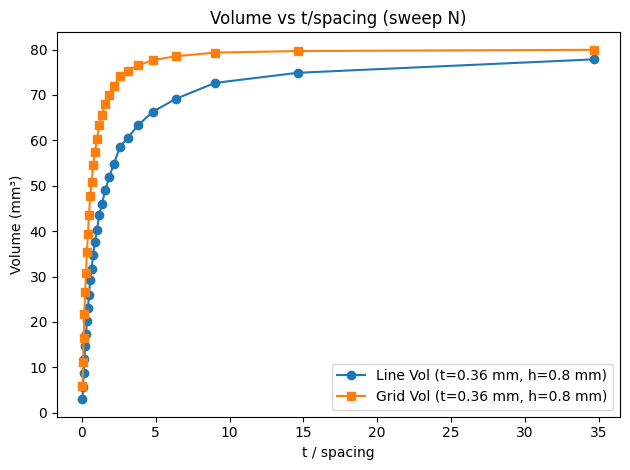

In [22]:
# ---------------- (B-Vol) Sweep N: Volume plot ----------------
# Volume = A2D * h  (mm^3)
V_line_B, V_grid_B = [], []
for N in N_vals:
    if N * t_fix >= W:
        continue
    r = ratio_t_over_spacing(W, int(N), t_fix)
    if not np.isfinite(r) or r <= 0:
        continue
    out = compute_surface_areas(int(N), t_fix, h_fixB, width=W, res=res)
    V_line_B.append(out['lines']['A2D'] * h_fixB)
    V_grid_B.append(out['grid']['A2D']  * h_fixB)

# intersections for Volume (B)
ints_B_vol = find_intersections(ratios_B, V_line_B, V_grid_B)

plt.figure()
plt.plot(ratios_B, V_line_B, '-o', label=f"Line Vol (t={t_fix} mm, h={h_fixB} mm)")
plt.plot(ratios_B, V_grid_B, '-s', label=f"Grid Vol (t={t_fix} mm, h={h_fixB} mm)")
if ints_B_vol:
    xs, ys = zip(*ints_B_vol)
    print("Volume intersections (sweep N):", xs)
    plt.plot(xs, ys, 'ro', label="Intersection")
plt.xlabel("t / spacing")
plt.ylabel("Volume (mm³)")
plt.title("Volume vs t/spacing (sweep N)")
plt.legend()
plt.tight_layout()
plt.show()


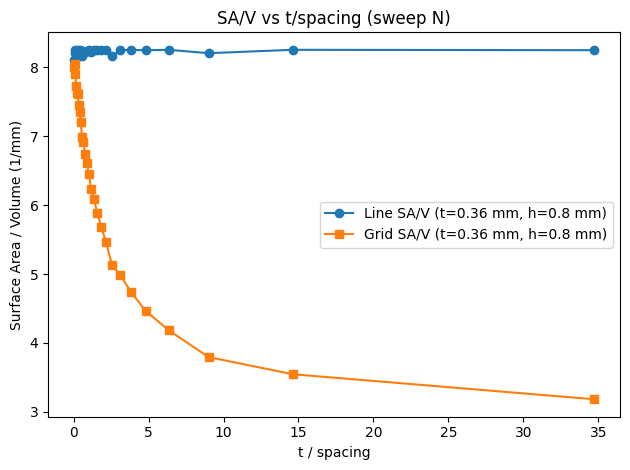

In [23]:
# ---------------- (B-SAV) Sweep N: SA/V ratio ----------------
SAV_line_B, SAV_grid_B = [], []
for N in N_vals:
    if N * t_fix >= W:
        continue
    r = ratio_t_over_spacing(W, int(N), t_fix)
    if not np.isfinite(r) or r <= 0:
        continue
    out = compute_surface_areas(int(N), t_fix, h_fixB, width=W, res=res)
    V_line = out['lines']['A2D'] * h_fixB
    V_grid = out['grid']['A2D']  * h_fixB
    SAV_line_B.append(out['lines']['SA3D'] / V_line)
    SAV_grid_B.append(out['grid']['SA3D']  / V_grid)

# intersections for SA/V
ints_B_sav = find_intersections(ratios_B, SAV_line_B, SAV_grid_B)

plt.figure()
plt.plot(ratios_B, SAV_line_B, '-o', label=f"Line SA/V (t={t_fix} mm, h={h_fixB} mm)")
plt.plot(ratios_B, SAV_grid_B, '-s', label=f"Grid SA/V (t={t_fix} mm, h={h_fixB} mm)")
if ints_B_sav:
    xs, ys = zip(*ints_B_sav)
    print("SA/V intersections (sweep N):", xs)
    plt.plot(xs, ys, 'ro', label="Intersection")
plt.xlabel("t / spacing")
plt.ylabel("Surface Area / Volume (1/mm)")
plt.title("SA/V vs t/spacing (sweep N)")
plt.legend()
plt.tight_layout()
plt.show()

